In [283]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape, Input, Dot
from keras.layers.merge import Concatenate
# X_single, y_single = load_npy("test_single")
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.layers import merge
from keras import backend as K
from keras.models import Model

MAX_LEN = 4
input_shape = (32,32,1)

regularizer = l2()
img_input = Input(shape=input_shape)

cnn = Sequential()
cnn.add(Conv2D(16, (3, 3), padding="same", input_shape=input_shape, kernel_regularizer=regularizer)) # L1
cnn.add(Activation('relu')) 
cnn.add(BatchNormalization()) # L2
cnn.add(MaxPooling2D(pool_size=(2, 2))) # L3
#cnn.add(Dropout(0.5))


cnn.add(Conv2D(32, (3, 3),  padding="same", kernel_regularizer=regularizer)) # L4
cnn.add(Activation('relu')) 
cnn.add(BatchNormalization()) # L5
cnn.add(MaxPooling2D(pool_size=(2, 2))) # L6
#cnn.add(Dropout(0.5))

cnn.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=regularizer)) # L7
cnn.add(Activation('relu'))
cnn.add(BatchNormalization()) # L8
cnn.add(MaxPooling2D(pool_size=(2, 2))) #L9
cnn.add(Dropout(0.5))

cnn = cnn(img_input)
flat = Flatten()(cnn)

size = Dense(1024, kernel_regularizer=regularizer)(flat) # L10
size = Activation('relu') (size)
size = Dropout(0.5) (size)
size = Dense( MAX_LEN + 1, kernel_regularizer=regularizer)(size)
size_output = Activation('softmax', name="Length_Smax")(size)

size_input = Input(shape=( MAX_LEN + 1,))

digit_inputs = []
digit_outputs = []
digits_merged = []

# layer_s = Concatenate()([flat, size_output])

# FIXME use RNN
for i in range(MAX_LEN):
    digit_output = Dense(10, kernel_regularizer=regularizer)(flat)
    digit_output = Activation('softmax', name="Digit_Last_Smax_{}".format(i))(digit_output)
    digit_input = Input(shape=(10,))
    
    digit_inputs.append(digit_input)
    digit_outputs.append(digit_output)

def sequence_probability(inputs):
    #y_pred, y_true = inputs
    len_pred, *digits_pred = inputs[:MAX_LEN + 1]
    len_true, *digits_true = inputs[MAX_LEN + 1:]

    # n_digits = 6
    
    pS = K.ones_like( len_true[:, 0] )
    b = K.zeros_like( len_true[:, 0] )
    ones = K.ones_like( len_true[:, 0])
    
    for i in range(MAX_LEN):
        b += len_true[:, - (i+1)]
        ps = K.sum(digits_true[i] * digits_pred[i], axis=1)
        pS = pS * ( ones - b + ps * b )
    ps = K.sum( len_pred * len_true, axis=1)
    pS = pS * ps
    return K.reshape(pS, (-1,1))

y_pred = [size_output,] + digit_outputs
y_true = [size_input,] + digit_inputs

# FIXME can the merge layer be used to compute loss?
prob_output = merge(y_pred + y_true, mode=sequence_probability, output_shape=(1,), name="Last")
#prob_output = Reshape((1,))(prob_output)

opt = RMSprop()

# use this for training
model = Model(inputs=[img_input, size_input] + digit_inputs, outputs=prob_output)

# use this to predict
estimator = Model(inputs=[img_input], outputs=[size_output,] + digit_outputs)

model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

/Users/skmohan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/skmohan/.virtualenv/tensorflow/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
sequential_6 (Sequential)        (None, 4, 4, 64)      23744                                        
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 1024)          0                                            
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 1024)          1049600                                      
___________________________________________________________________________________________

In [284]:
from keras.datasets import mnist

In [285]:
from keras.preprocessing.image import array_to_img, img_to_array
from IPython.display import display

In [286]:
(mx_train, my_train), (mx_test, my_test) = mnist.load_data()

In [287]:
import numpy as np

In [288]:
np.vstack( ( np.zeros((2,2)), np.ones((2,2))) )

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [289]:
np.random.randint(0, 5, 3)

array([1, 0, 2])

In [290]:
def merge(samples, mode):
    # dimensions of MNIST data
    width, height = 28, 28
    blank = np.zeros((width, height))
    n_samples = len(samples)
    
    if mode == 0:
        # merge horizontally
        arr = np.vstack(samples).reshape((width * n_samples, height, 1))
    elif mode == 1:
        arr = np.hstack(samples).reshape((width, height * n_samples, 1))
    elif mode == 2:
        digits = []
        for i, sample in enumerate(samples):
            digits.append( np.vstack([blank,] * i + [sample,] + [blank,] * (n_samples - i - 1)) )
        arr = np.hstack(digits).reshape((width * n_samples, height * n_samples, 1))
    elif mode == 3:
        digits = []
        for i, sample in enumerate(samples):
            digits.append( np.vstack([blank,] * (n_samples - i - 1) + [sample,] + [blank,] * i))
        arr = np.hstack(digits).reshape((width * n_samples, height * n_samples, 1))
    else:
        raise Exception("Unknown Mode {}".format(mode))
    return arr

def gen_samples(x_in, y_in, n_samples, size=(32,32)):
    #n_samples = 10000
    width, height = size
    samples = np.random.choice(len(x_in), [n_samples, MAX_LEN], replace=True)

    xs = np.empty((n_samples, width, height, 1))
    ys = [ np.zeros((n_samples, MAX_LEN+1)) ] + [ np.zeros((n_samples, 10)) for i in range(MAX_LEN)]

    # ys[0][:, 2] = 1 # all numbers are of length = 2 for now
    blank = np.zeros((28,28))
    
    for i, sample in enumerate(samples):
        digits = []
        for j in range( i % MAX_LEN, MAX_LEN):
            digit = y_in[sample[j]]
            if digit > 0 or len(digits) > 0 or j == MAX_LEN - 1:
                digits.append(x_in[sample[j]])
            ys[j+1][i, digit] = 1

        assert len(digits) > 0
        ys[0][i, len(digits)] = 1
        ix = i % 4
        arr = merge(digits, ix)
        xs[i] = img_to_array( array_to_img(arr).resize((width, height)))        
    return xs, ys    


In [268]:
xs, ys = gen_samples(mx_train, my_train, 10)

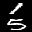

[2, 1, 5]


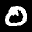

[1, 0, 0]


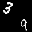

[2, 3, 9]


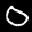

[1, 0, 0]


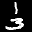

[2, 1, 3]


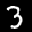

[1, 0, 3]


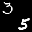

[2, 3, 5]


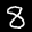

[1, 0, 8]


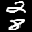

[2, 2, 8]


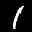

[1, 0, 1]


In [269]:
for i in range(len(xs)):
    display(array_to_img(xs[i]))
    print([yi[i].argmax() for yi in ys])

In [270]:
x_train, y_train = gen_samples(mx_train, my_train, 60000)
x_test, y_test = gen_samples(mx_test, my_test, 6000)

In [271]:
digits = y_train[0].argmax(axis=1)

for i in range(MAX_LEN):
    print("Digits with size {} = {}".format(i+1, (digits == i+1).sum()))

Digits with size 1 = 32943
Digits with size 2 = 27057


[2, 2, 7]


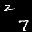

In [255]:
print([yi[10].argmax() for yi in y_train])
array_to_img(x_train[10])

In [ ]:
history = model.fit([ x_train, ] + y_train, np.ones(x_train.shape[0]),
          validation_split=0.2, 
          epochs=10,
          batch_size=32)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 154s - loss: 0.4956 - acc: 0.9234 - val_loss: 0.4087 - val_acc: 0.9435

In [273]:
history.history

{'acc': [0.92343750000000002,
  0.92739583333333331,
  0.92900000000000005,
  0.93112499999999998,
  0.92997916666666669,
  0.93127083333333338,
  0.92995833333333333,
  0.92970833333333336,
  0.93066666666666664,
  0.93195833333333333],
 'loss': [0.49564958081642785,
  0.45199885287880898,
  0.44574132859706878,
  0.43672591986258824,
  0.44080646689732872,
  0.43305371377865476,
  0.43821752278010051,
  0.43921511809031166,
  0.4344779137869676,
  0.43446395798524223],
 'val_acc': [0.94350000000000001,
  0.94308333333333338,
  0.94358333333333333,
  0.93500000000000005,
  0.93166666666666664,
  0.92733333333333334,
  0.91283333333333339,
  0.92533333333333334,
  0.9395,
  0.91958333333333331],
 'val_loss': [0.40865507411956786,
  0.40109008487065634,
  0.40534167861938475,
  0.41409601835409798,
  0.41922202277183535,
  0.4382874850432078,
  0.49967741441726682,
  0.44802841639518737,
  0.40432184060414633,
  0.46967649992307026]}

In [62]:
history = model.fit([ x_train, ] + y_train, np.ones(x_train.shape[0]),
          validation_split=0.2, 
          epochs=5,
          batch_size=32)

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 22s - loss: 3.3665 - acc: 0.4951 - val_loss: 1.3402 - val_acc: 0.8500

In [56]:
from IPython.display import display
from keras.preprocessing.image import array_to_img



def accuracy_single(y_true, y_pred):
    len_true = y_true[0]
    digits_true = y_true[1:]
    
    len_pred = y_pred[0]
    digits_pred = y_pred[1:]
    n_samples = len(len_pred)

    # n_digits = 6

    pS = np.ones_like( len_true[:, 0] )
    b = np.zeros_like( len_true[:, 0] )
    ones = np.ones_like( len_true[:, 0])
    b_pred = np.zeros_like( len_pred[:, 0] )

    len_pred = np.zeros_like(y_pred[0])
    len_pred[ np.arange(n_samples), y_pred[0].argmax(axis=1) ] = 1

    total_digits = 0
    correct_digits = 0

    for i in range(MAX_LEN):
        b += len_true[:, - (i+1)]
        b_pred += len_pred[:, - (i+1)]
        #print(i, b)
        d_pred = digits_pred[i].argmax(axis=1)
        d_true = digits_true[i].argmax(axis=1)
        correct_digits += ( (d_pred * b_pred)[b >= 1] == d_true[b >= 1]).sum()
        # print(i, correct_digits)
        # print(d_pred * b_pred)
        total_digits += b.sum()
    return correct_digits, int(total_digits)

def accuracy_multi(y_true, y_pred):
    n = y_true[0].shape[0]
    seq_len = np.argmax(y_pred[0], axis=1) #[samples]

    seq_pred = np.sum( [ (seq_len > MAX_LEN - i)
                            * np.argmax(y_pred[i], axis=1) 
                            * 10**(MAX_LEN-i) for i in range(1, MAX_LEN+1) ], 
                axis=0)
    seq_true = np.sum([ np.argmax(y_true[i], axis=1) * 10**(MAX_LEN-i) for i in range(1,MAX_LEN+1)], axis=0)
    return (seq_pred == seq_true).sum(), n

def accuracy_length(y_true, y_pred):
    len_pred = y_pred[0].argmax(axis=1)
    len_true = y_true[0].argmax(axis=1)
    return (len_pred == len_true).sum(), len(len_true)
    
def performance(y_true, y_pred):
    #loss = digit_loss( y_true[1:], y_pred[1:] )
    #print("Loss : {}".format( np.product(loss))) # XXX Not sure what this means
    correct_digits, total_digits = accuracy_single(y_true, y_pred)
    print("\tAccuracy (single): {:.2%} ({}/{})".format(correct_digits/total_digits, correct_digits, total_digits))
    correct_seq, total_seq = accuracy_multi(y_true, y_pred)
    print("\tAccuracy (seq): {:.2%} ({}/{})".format(correct_seq/total_seq, correct_seq, total_seq))
    correct_len, n_samples = accuracy_length(y_true, y_pred)
    print("\tAccuracy (length): {:.2%} ({}/{})".format(correct_len/n_samples, correct_len, n_samples))    

def review(X_true, y_true, nsamples=5, samples=None):
    if samples is  None:
        samples = np.random.choice(X_true.shape[0], nsamples)

    print("Samples: ", samples)
    y_pred = estimator.predict(X_true[samples])
    y_true_ = [ y_true[i][samples] for i in range(MAX_LEN+1) ]

    performance( y_true_, y_pred)

    for s,sample in enumerate(samples):
        size_pred = np.argmax( y_pred[0][s] )
        num_pred = "".join(map(str, [np.argmax(y_pred[i+1][s]) for i in range(MAX_LEN - size_pred, MAX_LEN)] ))

        size_true = np.argmax( y_true_[0][s] )
        num_true = "".join(map(str, [np.argmax(y_true_[i+1][s]) for i in range(MAX_LEN - size_true, MAX_LEN)] ))
        probability = np.product( [ (y_pred[i+1][s] * y_true_[i+1][s]).sum() for i in range(MAX_LEN-size_true, MAX_LEN) ] )
        probability *= y_pred[0][s][size_true]
        
        print(" # {}".format(sample))
        print( "Predicted {:>6} ({}) {}".format(num_pred, size_pred, "✓" if num_pred == num_true else "✗"))
        print( "Actual    {:>6} ({})".format(num_true, size_true))
        print( "Probability: {}".format(probability))
        # print( num_pred == num_true )
        display(array_to_img(X_true[sample]))


Samples:  [3291 1687 5367 1264 5552]
	Accuracy (single): 100.00% (7/7)
	Accuracy (seq): 100.00% (5/5)
	Accuracy (length): 100.00% (5/5)
 # 3291
Predicted      7 (1) ✓
Actual         7 (1)
Probability: 0.9976926016443599


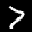

 # 1687
Predicted      5 (1) ✓
Actual         5 (1)
Probability: 0.9877677567775862


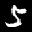

 # 5367
Predicted      6 (1) ✓
Actual         6 (1)
Probability: 0.9999470715393244


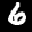

 # 1264
Predicted     68 (2) ✓
Actual        68 (2)
Probability: 0.9981634116230284


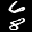

 # 5552
Predicted     99 (2) ✓
Actual        99 (2)
Probability: 0.7805541720902064


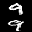

In [280]:
review(x_test, y_test)

In [281]:
y_pred = estimator.predict(x_train)
performance(y_train, y_pred)

	Accuracy (single): 95.75% (83353/87057)
	Accuracy (seq): 93.83% (56295/60000)
	Accuracy (length): 99.91% (59945/60000)


In [282]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

	Accuracy (single): 95.42% (8321/8720)
	Accuracy (seq): 93.35% (5601/6000)
	Accuracy (length): 99.92% (5995/6000)


In [100]:
model.save("./svhn_synthetic.h5")